Importing various libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import seaborn as sb


## Keras
import keras
import tensorflow
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.applications import ResNet50

from google.colab.patches import cv2_imshow
import cv2
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the *driving_log.csv* file containing all the data

In [ ]:
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv('/content/drive/Shareddrives/ITSP_Project/driving_log.csv', names = columns)
pd.set_option('display.max_colwidth', None)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\center_2022_06_27_00_34_04_928.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\left_2022_06_27_00_34_04_928.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\right_2022_06_27_00_34_04_928.jpg,0.0,0.0,0.0,4.760791e-06
1,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\center_2022_06_27_00_34_05_006.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\left_2022_06_27_00_34_05_006.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\right_2022_06_27_00_34_05_006.jpg,0.0,0.0,0.0,2.493116e-06
2,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\center_2022_06_27_00_34_05_085.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\left_2022_06_27_00_34_05_085.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\right_2022_06_27_00_34_05_085.jpg,0.0,0.0,0.0,1.406749e-05
3,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\center_2022_06_27_00_34_05_162.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\left_2022_06_27_00_34_05_162.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\right_2022_06_27_00_34_05_162.jpg,0.0,0.0,0.0,1.104498e-05
4,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\center_2022_06_27_00_34_05_240.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\left_2022_06_27_00_34_05_240.jpg,C:\Users\Admin\Downloads\beta_simulator_windows\IMG\right_2022_06_27_00_34_05_240.jpg,0.0,0.0,0.0,5.368020e-07


Defined function *path_leaf()* to get name of the image

In [ ]:
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail

Applying the function *path_leaf()* to first 3 columns of DataFrame *data*

In [ ]:
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2022_06_27_00_34_04_928.jpg,left_2022_06_27_00_34_04_928.jpg,right_2022_06_27_00_34_04_928.jpg,0.0,0.0,0.0,4.760791e-06
1,center_2022_06_27_00_34_05_006.jpg,left_2022_06_27_00_34_05_006.jpg,right_2022_06_27_00_34_05_006.jpg,0.0,0.0,0.0,2.493116e-06
2,center_2022_06_27_00_34_05_085.jpg,left_2022_06_27_00_34_05_085.jpg,right_2022_06_27_00_34_05_085.jpg,0.0,0.0,0.0,1.406749e-05
3,center_2022_06_27_00_34_05_162.jpg,left_2022_06_27_00_34_05_162.jpg,right_2022_06_27_00_34_05_162.jpg,0.0,0.0,0.0,1.104498e-05
4,center_2022_06_27_00_34_05_240.jpg,left_2022_06_27_00_34_05_240.jpg,right_2022_06_27_00_34_05_240.jpg,0.0,0.0,0.0,5.368020e-07


Plotting distribution of rotation

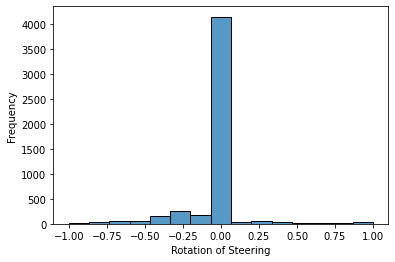

In [ ]:
sb.histplot(data['steering'], bins=15)
plt.xlabel('Rotation of Steering')
plt.ylabel('Frequency')
plt.show()

Above plot shows the car mostly has 0 rotation which is due to the straight path and plot also shows some bias towards the negative values which is due to the more frequent left turns than right

Loading all the image paths and value of rotation to *image_paths* and *steerings*

In [ ]:
def load_img_steering(df):
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center = indexed_data[0]
    image_path.append('/content/drive/Shareddrives/ITSP_Project/IMG/' + center)
    steering.append(indexed_data[3])
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(data)

Applying Data Augmentation to reduce the bias

In [ ]:
import matplotlib.image as mpimg
from imgaug import augmenters as iaa

def augmentImage(imgPath,steering):
    img =  mpimg.imread(imgPath)
    if np.random.rand() < 0.5:
      pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
      img = pan.augment_image(img)
    if np.random.rand() < 0.5:
      zoom = iaa.Affine(scale=(1, 1.2))
      img = zoom.augment_image(img)
    if np.random.rand() < 0.5:
      brightness = iaa.Multiply((0.2, 1.2))
      img = brightness.augment_image(img)
    if np.random.rand() < 0.5:
      img = cv2.flip(img, 1)
      steering = -steering
    return img, steering

In [ ]:
aug_image = []
aug_steering = []
for i in range(len(image_paths)):
  img1, steering1 = augmentImage(image_paths[i], steerings[i])
  aug_image.append(img1)
  aug_steering.append(steering1)

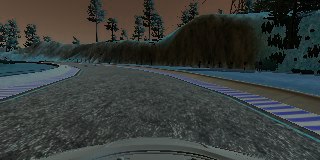

In [ ]:
cv2_imshow(aug_image[0])

Splitting the data into training and validation set

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(aug_image, aug_steering, test_size = 0.25, random_state=10)

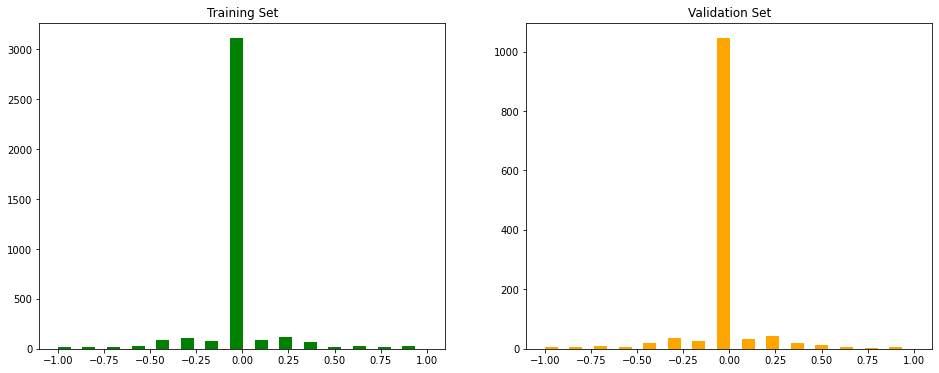

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(y_train, width=0.07, bins=15, color="green")
axes[0].set_title('Training Set')
axes[1].hist(y_valid, width=0.07, bins=15, color="orange")
axes[1].set_title('Validation Set')

plt.show()

Above plot shows the data is evenly distributed in both training and validation set

Reading and viewing sample image

In [ ]:
demo_img_array = cv2.imread(image_paths[0])
demo_img_array.shape

(160, 320, 3)

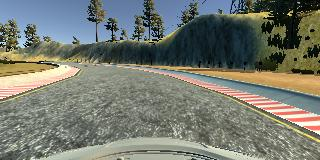

In [ ]:
cv2_imshow(demo_img_array)

Defining function *img_preprocess* to do some preprocessing on image

In [ ]:
def img_preprocess(img):
  #img = cv2.imread(img)
  img = img[50:140,:,:]
  img = cv2.GaussianBlur(img, (5, 5), 0)
  img = cv2.resize(img, (100, 100))
  img = img / 255
  return img

Viewing image before and after preprocessing

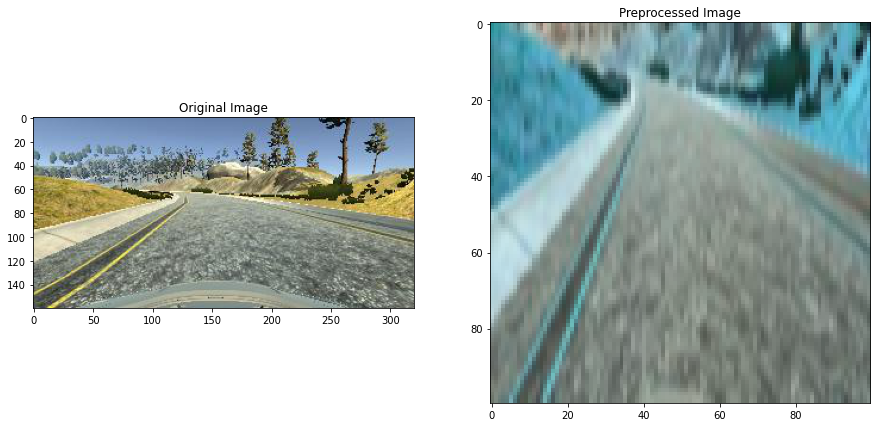

In [ ]:
image = image_paths[150]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))

axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

plt.show()

Applying preprocessing to image datasets using function *img_preprocess()*

In [ ]:
x_train = np.array(list(map(img_preprocess, x_train)))
x_valid = np.array(list(map(img_preprocess, x_valid)))

Using ResNet50 and freezing its all but last 4 layers

In [ ]:
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))
for layer in resnet.layers[:-4]:
  layer.trainable = False
print(resnet.summary())

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

Adding few extra layers in ResNet50

In [ ]:
model = Sequential()
model.add(resnet)
model.add(Conv2D(filters=32, kernel_size=2, activation='relu', kernel_initializer=RandomNormal(mean=0, stddev=0.16)))
model.add(Conv2D(filters=8, kernel_size=2, activation='relu', kernel_initializer=RandomNormal(mean=0, stddev=0.16)))
model.add(Flatten())
model.add(Dense(8, activation='relu', kernel_initializer=RandomNormal(mean=0, stddev=0.16)))
model.add(Dropout(0.5))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate = 0.001), loss='mse', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 3, 3, 32)          262176    
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 8)           1032      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9

Training the model

In [ ]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)

In [ ]:
n_epochs = 5

In [ ]:
history = model.fit(x_train, y_train, batch_size=350, epochs=n_epochs, validation_data=(x_valid, y_valid), verbose=1, shuffle=1)

Epoch 1/5
11/11 [==============================] - 177s 17s/step - loss: 0.0665 - accuracy: 0.8079 - val_loss: 0.0666 - val_accuracy: 0.8182
Epoch 2/5
11/11 [==============================] - 173s 16s/step - loss: 0.0423 - accuracy: 0.8079 - val_loss: 0.0367 - val_accuracy: 0.8182
Epoch 3/5
11/11 [==============================] - 173s 16s/step - loss: 0.0360 - accuracy: 0.8079 - val_loss: 0.0313 - val_accuracy: 0.8182
Epoch 4/5
11/11 [==============================] - 176s 16s/step - loss: 0.0360 - accuracy: 0.8079 - val_loss: 0.0310 - val_accuracy: 0.8182
Epoch 5/5
11/11 [==============================] - 174s 16s/step - loss: 0.0360 - accuracy: 0.8079 - val_loss: 0.0310 - val_accuracy: 0.8182


Plotting Training vs Validation Loss

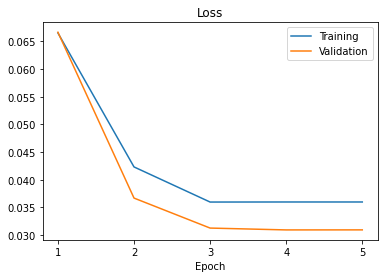

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.xlim()
plt.ylim()
plt.xticks(ticks=range(n_epochs), labels=range(1,n_epochs+1))
plt.show()

Saving model for further testing it

In [ ]:
model.save('model3.h5')